In [1]:
%cd ..

/work/yuxiang1234/sandbox-AND


## Import packages

In [2]:
import json
import os
import pickle
import random
import sys
from collections import defaultdict

import numpy as np
import torch
import torch.nn.utils.prune as prune
from pruning.audio_dataset import ESC50Dataset, collate_batch
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoProcessor

from args import parser
from data_utils import (get_label_to_cls, get_target_model, read_json, get_cls_label, mean)
from sentence_utils import get_basename


/home/yuxiang1234/env/dissect/lib/python3.8/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yuxiang1234/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Arguments

In [3]:
class Arguments:
    def __init__(self):

        self.target_name = "ast-esc50" # Model to dissect (target model)
        
        self.target_layers = "layer0_output,layer0_intermediate,layer0_attention_output, \
                        	  layer1_output,layer1_intermediate,layer1_attention_output, \
                              layer2_output,layer2_intermediate,layer2_attention_output, \
                              layer3_output,layer3_intermediate,layer3_attention_output, \
                              layer4_output,layer4_intermediate,layer4_attention_output, \
                              layer5_output,layer5_intermediate,layer5_attention_output, \
                              layer6_output,layer6_intermediate,layer6_attention_output, \
                              layer7_output,layer7_intermediate,layer7_attention_output, \
                              layer8_output,layer8_intermediate,layer8_attention_output, \
                              layer9_output,layer9_intermediate,layer9_attention_output, \
                              layer10_output,layer10_intermediate,layer10_attention_output, \
                              layer11_output,layer11_intermediate,layer11_attention_output"
        # Which layer neurons to describe. String list of layer names to describe, separated by comma (no spaces). 
        # Follows the naming format of the Pytorch module used.

        # For beats
        # self.target_layers = "layer0_1,layer0_2,layer1_1,layer1_2,layer2_1,layer2_2,layer3_1,layer3_2,layer4_1,layer4_2,layer5_1,layer5_2,layer6_1,layer6_2,layer7_1,layer7_2,layer8_1,layer8_2,layer9_1,layer9_2,layer10_1,layer10_2,layer11_1,layer11_2"
        
        self.probing_dataset = "esc50"  # Probing dataset to probe the target model
        self.concept_set_file = "data/concept_set/esc50.txt"  # Path to txt file of concept set
        self.network_class_file = "data/network_class/esc50.txt"  # Path to txt file of network's classification class
        self.clip_model = "ViT-B/32"  # CLIP model version to use
        self.clap_model = "ViT-B/32"  # CLAP model version to use
        self.sentence_transformer = 'all-MiniLM-L12-v2'  # Sentence transformer to use
        self.batch_size = 1  # Batch size when running CLIP/target model
        self.device = "cuda"  # Whether to use GPU/which GPU
        self.seed = 20  # Seed number
        self.num_of_gpus = 1  # Number of available GPUs for vllm
        self.pool_mode = "avg"  # Aggregation function for channels
        self.scoring_func = False  # Scoring function flag

        # Directory paths
        self.audio_description_dir = "audio_description"  # Directory to save audio descriptions
        self.audio_dir = "save_audios"  # Directory to save audio
        self.save_activation_dir = "saved_activations"  # Directory to save activation values
        self.save_summary_dir = "summaries"  # Directory to save summaries
        self.save_discriminative_sample_dir = "discriminative_samples"  # Directory to save discriminative samples
        self.save_prediction_dir = "prediction"  # Directory to save prediction
        self.save_interpretability_dir = 'interpretability'  # Directory to save interpretability experiments

        # Discriminative settings
        self.discriminative_type = "highly"  # Type of discriminative samples
        self.post_process_type = "sim"  # Post-processing type
        self.mutual_info_threshold = 0.6  # Mutual information threshold
        self.K = 5  # Top-K highly/lowly-activated audio
        self.clusters = 11  # Number of clusters

        # LLM settings
        self.llm = "meta-llama/Llama-2-13b-chat-hf"  # LLM to use
        self.top_p = 1.0  # Sampling parameter: top-p
        self.temperature = 1.0  # Sampling parameter: temperature
        self.max_tokens = 128  # Sampling parameter: max tokens
        self.ICL_topk = 1  # Experiments of top5 or top1 accuracy of ICL

        # Pruning settings
        self.save_pruning_dir = "pruning_result"  # Directory to save pruning results
        self.max_pruned_num = 3000  # Maximum number of pruned neurons
        self.pruned_concepts = ["water_drops"]  # Concepts to be ablated
        self.pruning_strategy = "ocp"  # Method to decide pruned neurons (random, db, tab, ocp)

In [4]:
args = Arguments()

### Pruning

In [7]:
random.seed(args.seed)

label_to_cls = get_label_to_cls(args.network_class_file)

if args.pruning_strategy == "tab":
	prediction_file = os.path.join(args.save_prediction_dir, f"tab-{args.target_name}-top{args.K}.json")
elif args.pruning_strategy == "db": 
	prediction_file = os.path.join(args.save_prediction_dir, f"db-{args.target_name}-top{args.K}.json")
# "random" needs neurons names
elif args.pruning_strategy == "ocp" or args.pruning_strategy == "random": 
	prediction_file = os.path.join(args.save_summary_dir, f"calibration_{args.target_name}_{args.probing_dataset}_{get_basename(args.concept_set_file)}_top{args.K}.json")

prediction = read_json(prediction_file)
if args.pruning_strategy == "random":
	_ = list(prediction.items())
	random.Random(args.seed).shuffle(_)
	prediction = dict(_)

if "ast" in args.target_name:
	input_dimension = {"attention_output":768, "intermediate": 768, "output":3072}
	processor = AutoProcessor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")	
elif "beats" in args.target_name: 
	input_dimension = {"1": 768, "2": 3072}
	processor = None

dataset = load_dataset("ashraq/esc50")
dev_dataset = ESC50Dataset(dataset, processor, mode='dev')

dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, pin_memory=True, collate_fn=collate_batch)

pruned_concepts = [None] + args.pruned_concepts

results = {}

for pruned_concept in pruned_concepts:
	mask_cnt = 0 
	pruned_neuron_record = defaultdict(int)
	masked_out_neurons = []
	masked_neuron = defaultdict(list)
	masked_neuron_bias = defaultdict(list)
	
	model = get_target_model(args.target_name, device=args.device)

	for key, _ in tqdm(prediction.items()):
		layer = key.split('#')[0]

		if layer == 'fc':
			continue

		layer = layer.split('_')

		layer_name = layer[1]
		layer_num = layer[0]

		# attention_output layer
		if len(layer) == 3:
			layer_name = layer[1] + '_' + layer[2]
		
		layer_id = layer_num.replace("layer", "")

		neuron_id = key.split('#')[1]
		dim = input_dimension[layer_name]

		flag = False
		if args.pruning_strategy == "ocp":
			nouns = prediction[key]['nouns']

			if pruned_concept is not None:
				for n in nouns:
					if n in pruned_concept: 
						flag = True 
						break		

		# We select the best simlarity function by last layer acc 
		elif args.pruning_strategy == "tab" :
			if pruned_concept is not None and pruned_concept in prediction[key]["soft_wpmi"]["prediction"][:3]:
				flag = True
		elif args.pruning_strategy == "db":
			if pruned_concept is not None and pruned_concept in prediction[key]["cos_similarity_cubed"]["prediction"][:3]:
				flag = True
		elif args.pruning_strategy == "random":
			if mask_cnt < args.max_pruned_num:
				flag = True

		# ablate this neuron
		if pruned_concept is not None and flag:
			pruned_neuron_record[layer_num + '_' + layer_name] += 1
			mask_cnt += 1
			masked_neuron[layer_num + "_" + layer_name].append([0 for _ in range(dim)])
			masked_out_neurons.append(f"{layer_name}_{layer_id}#{neuron_id}")
			masked_neuron_bias[layer_num + "_" + layer_name].append(0)
		else:
			masked_neuron[layer_num + "_" + layer_name].append([1 for _ in range(dim)])
			masked_neuron_bias[layer_num + "_" + layer_name].append(1)

	for key, mask in masked_neuron.items():
		layer_id = key.split("_")[0].replace("layer", "")
		layer_id = int(layer_id)
		layer_name = key.split("_")[1]
		
		if "ast" in args.target_name:
			if layer_name == "attention":
				module = model.audio_spectrogram_transformer.encoder.layer[layer_id].attention.output.dense
			elif layer_name == "intermediate":
				module = model.audio_spectrogram_transformer.encoder.layer[layer_id].intermediate.dense
			elif layer_name == "output":
				module = model.audio_spectrogram_transformer.encoder.layer[layer_id].output.dense
		elif "beats" in args.target_name: 
			if layer_name == "1":
				module = model.beats.encoder.layers[layer_id].fc1
			elif layer_name == "2": 
				module = model.beats.encoder.layers[layer_id].fc2

		weight_mask = torch.tensor(mask).to("cuda")
		bias_mask = torch.tensor(masked_neuron_bias[key]).to("cuda")

		prune.custom_from_mask(module, 'weight', mask=weight_mask)
		prune.custom_from_mask(module, 'bias', mask=bias_mask)
	
	wrong_record = []
	correct_by_class, total_by_class = defaultdict(int), defaultdict(int)
	pred_by_class = defaultdict(int)
	correct, total = 0, 0
	confidence_by_class = defaultdict(list)
	with torch.no_grad():
		for batch in tqdm(dev_loader):
			batch["input_values"] = batch["input_values"].to("cuda")
			batch["labels"] = batch["labels"].to("cuda")
			outputs = model(batch["input_values"])
			if "ast" in args.target_name:
				outputs = outputs.logits
			outputs_list = outputs.detach().cpu().tolist()
			outputs = torch.argmax(outputs, dim = -1)
			labels = batch["labels"]
			correct += torch.sum(outputs == labels).detach().cpu().item()
			total += outputs.shape[0]	
			
			outputs = outputs.detach().cpu().tolist()
			labels = labels.detach().cpu().tolist()
			for idx, (pred, gt, filename) in enumerate(zip(outputs, labels, batch['filenames'])):
				pred = label_to_cls[pred]
				gt = label_to_cls[gt]
				if (pred == gt):
					correct_by_class[pred] += 1
				else:
					wrong_record.append(filename)
				pred_by_class[pred] += 1
				total_by_class[gt] += 1
				confidence_by_class[gt].append(outputs_list[idx])

	print(pruned_concept)
	results[pruned_concept] = {}
	results[pruned_concept]["masked_count"] = len(masked_out_neurons)
	results[pruned_concept]["masked_neuron"] = masked_out_neurons
	results[pruned_concept]["correct"] = correct
	results[pruned_concept]["total"] = total
	results[pruned_concept]["correct_by_class"] = correct_by_class
	results[pruned_concept]["pred_by_class"] = pred_by_class
	results[pruned_concept]["total_by_class"] = total_by_class
	results[pruned_concept]["confidence"] = confidence_by_class

	print('mask_cnt: ', mask_cnt)

Found cached dataset parquet (/work/yuxiang1234/cache/ashraq___parquet/ashraq--esc50-1000c3b73cc1500f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /work/yuxiang1234/cache/ashraq___parquet/ashraq--esc50-1000c3b73cc1500f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-8aa9d6610af22639.arrow
Loading cached processed dataset at /work/yuxiang1234/cache/ashraq___parquet/ashraq--esc50-1000c3b73cc1500f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-d13104c871fa4d92.arrow
100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


None
mask_cnt:  0


100%|██████████| 4/4 [00:08<00:00,  2.20s/it]

water_drops
mask_cnt:  2651


### Evaluation

In [13]:
import pandas as pd

/tmp/ipykernel_8347/363184716.py:66: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.annotate('', xy=(x[i], y1[i]), xytext=(x[i], y2[i]),


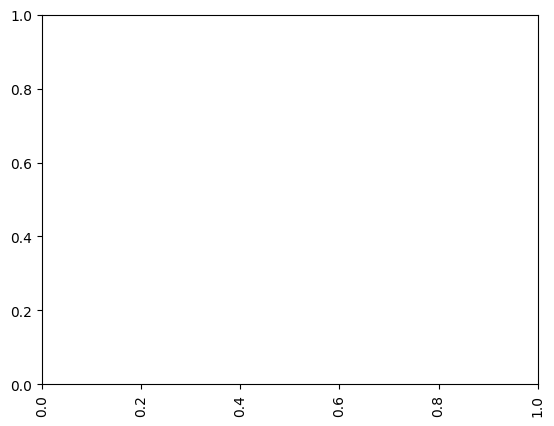

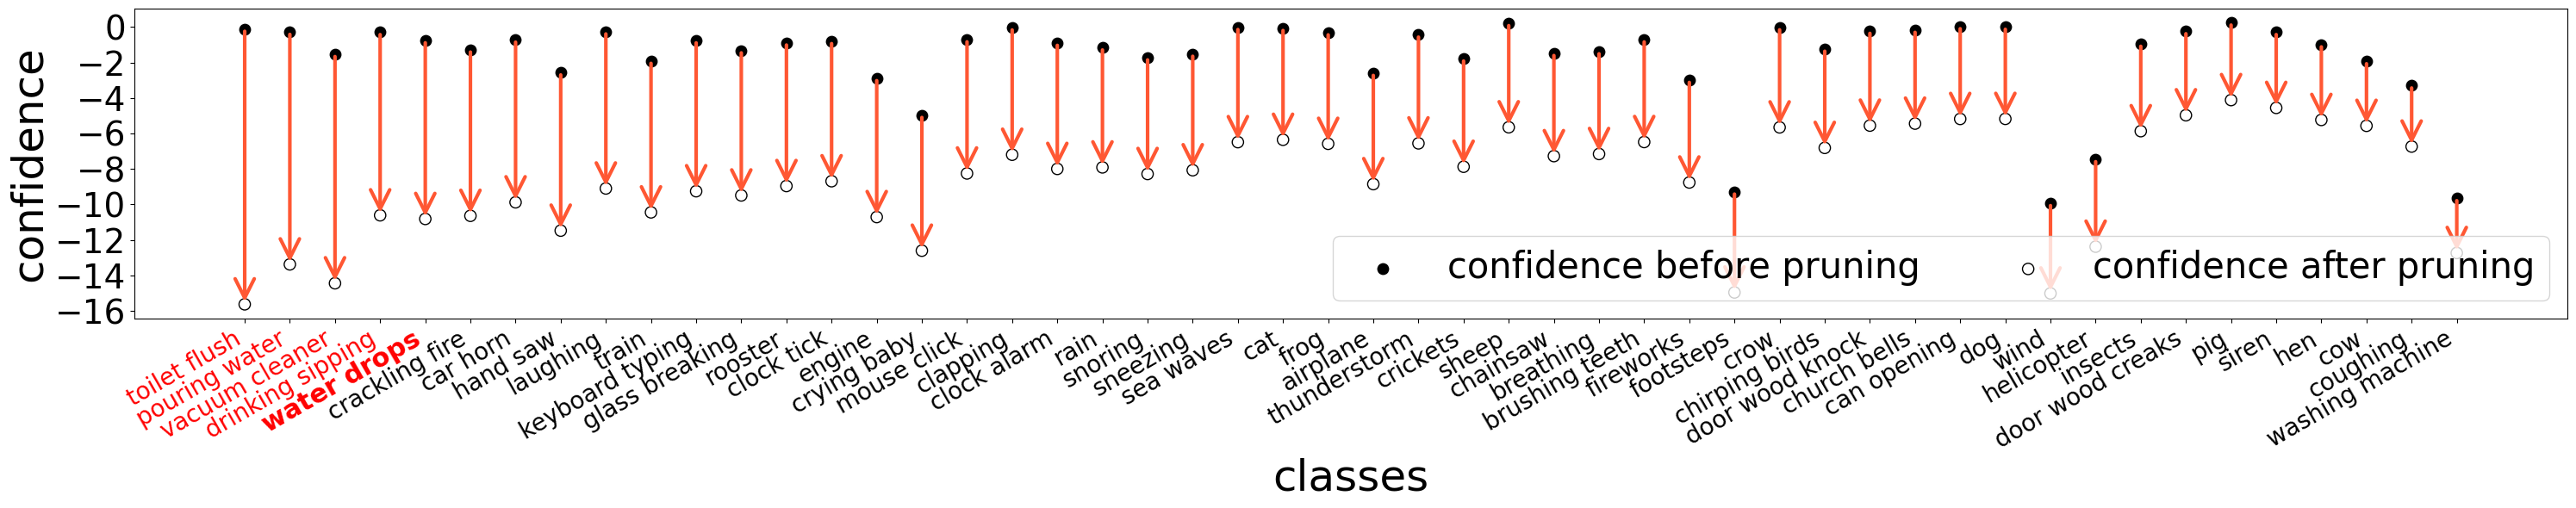

In [14]:
import matplotlib.pyplot as plt

for pruned_concept in args.pruned_concepts:

	acc_before_pruning = []
	acc_after_pruning = []

	classes = get_cls_label(args.network_class_file)

	masked_count_list = []
	obj = results[pruned_concept]

	confidence_before_avg = []
	confidence_avg = []

	for cls_idx, cls_name in enumerate(classes):
		confidence_before = results[None]["confidence"][cls_name]
		confidence_after = obj["confidence"][cls_name]
		
		# different samples
		c_b_avg = []
		c_a_avg = []
		for c_b, c_a in zip(confidence_before, confidence_after):
			c_b_avg.append(c_b[cls_idx])
			c_a_avg.append(c_a[cls_idx])

		confidence_before_avg.append(mean(c_b_avg))
		confidence_avg.append(mean(c_a_avg))

	prune_count = obj['masked_count']

	classes = [cls.replace("_", " ") for cls in classes]
	acc_before_pruning = confidence_before_avg
	acc_after_pruning = confidence_avg

	difference = [b - a for a, b in zip(acc_before_pruning, acc_after_pruning)]
	zipped = zip(difference, acc_before_pruning, acc_after_pruning, classes)
	zipped = sorted(zipped, reverse=False)
	difference, acc_before_pruning, acc_after_pruning, classes = zip(*zipped)

	df = pd.DataFrame({
		'Classes': classes,
		'Before pruning': acc_before_pruning,
		'After pruning':acc_after_pruning,
	})

	plt.xticks(rotation=90)

	# Sample data
	x = classes # Common x-values
	y1 = acc_after_pruning  # First set of y-values
	y2 = acc_before_pruning  # Second set of y-values

	# Plotting the points
	plt.figure(figsize=(30, 6))
	plt.scatter(x, y2, color='black',marker='o', s=80, label='confidence before pruning')  # Points for the first set
	plt.scatter(x, y1, color='black', marker='o', facecolors='none', s=90, label='confidence after pruning')  # Points for the second set

	# Connecting points with the same x-value
	for i in range(len(x)):
		if y1[i] > y2[i]:
			color = "#0047AB"
		else: 
			color = "#FF5733"
		if abs(y2[i] - y1[i]) > 0.1:
			plt.annotate('', xy=(x[i], y1[i]), xytext=(x[i], y2[i]),
						arrowprops=dict(facecolor='green', color=color, arrowstyle="->", lw=3, mutation_scale=40))

	# Adding titles and labels
	plt.xlabel('classes', fontsize=36)
	plt.ylabel('confidence', fontsize=36)
	plt.xticks(rotation=30, fontsize=20,  ha='right')
	plt.yticks(fontsize=28)
	plt.legend(loc="lower right",  fontsize="30", ncol=2)

	plt.gca().get_xticklabels()[0].set_color('red') 
	plt.gca().get_xticklabels()[1].set_color('red') 
	plt.gca().get_xticklabels()[2].set_color('red') 
	plt.gca().get_xticklabels()[3].set_color('red') 
	plt.gca().get_xticklabels()[4].set_color('red') 
	plt.gca().get_xticklabels()[4].set_fontsize(22) 
	plt.gca().get_xticklabels()[4].set_weight("bold")

	# Adjust layout to prevent overlap of titles
	plt.tight_layout()
	plt.savefig(os.path.join(args.save_pruning_dir, f'{args.pruning_strategy}_{args.probing_dataset}_{pruned_concept}.pdf'), format="pdf")
	plt.show()

